# Egocentric Data QC Pipeline — Egocentric-10K + SAM3

End-to-end pipeline: load one video from **builddotai/Egocentric-10K** (streaming), run **SAM3** video segmentation with a text prompt, and compute QC metrics.

## 1. Setup & installs

In [2]:
using_colab = True

In [ ]:
import sys
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    sys.path.append('/content')  # ensure Colab can see the file
    !{sys.executable} -m pip install opencv-python matplotlib scikit-learn
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam3.git'
else:
    ROOT = Path.cwd().parent
    sys.path.append(str(ROOT))

In [3]:
!nvidia-smi

Wed Jan 28 19:59:15 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## 2. HuggingFace Token

Egocentric-10K and SAM3 are gated. You must:

Accept the dataset terms on the Hub: https://https://huggingface.co/datasets/builddotai/Egocentric-10K

Request access to SAM3: https://huggingface.co/facebook/sam3

Create a token at huggingface.co/settings/tokens

Run the cell below and paste your token when prompted, or set the HF_TOKEN env var

In [4]:
from huggingface_hub import login
import os
# Use token from env (e.g. Colab secrets) or you'll be prompted to paste it
token = os.environ.get("HF_TOKEN")
login(token=token)

## 3. Load Egocentric Data

In [5]:
from datasets import load_dataset, Features, Value

# streaming=True: no full download — only the next sample is fetched when we iterate (one clip at a time).
features = Features({
    "mp4": Value("binary"),
    "json": {
        "factory_id": Value("string"),
        "worker_id": Value("string"),
        "video_index": Value("int64"),
        "duration_sec": Value("float64"),
        "width": Value("int64"),
        "height": Value("int64"),
        "fps": Value("float64"),
        "size_bytes": Value("int64"),
        "codec": Value("string"),
    },
    "__key__": Value("string"),
    "__url__": Value("string"),
})

dataset = load_dataset("builddotai/Egocentric-10K", streaming=True, features=features)
iter_dataset = iter(dataset["train"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.42k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/21643 [00:00<?, ?it/s]

In [6]:
# Fetch exactly one sample (only this one is downloaded; full 10K is never stored).
sample = next(iter_dataset)
mp4_bytes = sample["mp4"]
meta = sample.get("json") or {}
clip_id = sample.get("__key__") or "egocentric_10k_sample_0"

# Write video to local file (Colab: /content/ if needed)
import os
os.makedirs("/content", exist_ok=True)
input_video_path = f"/content/{clip_id}.mp4"
with open(input_video_path, "wb") as f:
    f.write(mp4_bytes)
print("Saved:", input_video_path)

# Print metadata (defensive about missing fields)
duration = meta.get("duration_sec")
fps = meta.get("fps")
w, h = meta.get("width"), meta.get("height")
print("duration_sec:", duration)
print("fps:", fps)
print("width x height:", w, "x", h)
print("clip_id:", clip_id)

Saved: /content/factory001_worker001_00000.mp4
duration_sec: 433.395
fps: 30.0
width x height: 1920 x 1080
clip_id: factory001_worker001_00000


In [ ]:
import gc
from src.process_data import process_video
from src.inference import run_inference_on_video

#Convert video to frames
frames_dir = process_video(input_video_path)

# Free RAM before building the predictor (frames reloaded from disk for overlay later)
gc.collect()
try:
    import torch
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
except Exception:
    pass

Processing video: /content/factory001_worker001_00000.mp4
Reading frames from video: /content/factory001_worker001_00000.mp4
Extracted 200 frames from video
Writing 200 frames to directory...
Wrote 200 frames to /tmp/sam3_frames_45dgsygn
Completed processing: /content/factory001_worker001_00000.mp4


## 4. Build SAM3 Predictor and Inference


In [10]:
import os
import torch
import sam3
from sam3.model_builder import build_sam3_video_predictor

sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")

# use all available GPUs on the machine
gpus_to_use = range(torch.cuda.device_count())

predictor = build_sam3_video_predictor(gpus_to_use=gpus_to_use)

#Run inference
outputs_per_frame = run_inference_on_video(frames_dir, predictor, gpus_to_use, prompt_text_str = "hands")

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
INFO 2026-01-28 20:01:01,569 4456 sam3_video_predictor.py: 300: using the following GPU IDs: [0]
INFO 2026-01-28 20:01:01,732 4456 sam3_video_predictor.py: 316: 


	*** START loading model on all ranks ***


INFO 2026-01-28 20:01:01,733 4456 sam3_video_predictor.py: 318: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2026-01-28 20:01:11,204 

config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

sam3.pt:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

INFO 2026-01-28 20:01:29,164 4456 sam3_video_predictor.py: 320: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2026-01-28 20:01:29,165 4456 sam3_video_predictor.py: 331: 


	*** DONE loading model on all ranks ***





=== Starting inference on video: /tmp/sam3_frames_45dgsygn ===
Using prompt text: 'hands'
Starting new session...


frame loading (image folder) [rank=0]: 100%|██████████| 200/200 [00:07<00:00, 25.50it/s]


Session started with session_id: 3d5afd35-1f2f-4e65-a6b3-77335ff88598
Adding text prompt on frame 0...
Prompt added successfully
Starting propagation in video for session_id: 3d5afd35-1f2f-4e65-a6b3-77335ff88598


propagate_in_video:   0%|          | 0/200 [00:00<?, ?it/s]

Processed 10 frames...
Processed 20 frames...
Processed 30 frames...
Processed 40 frames...
Processed 50 frames...
Processed 60 frames...
Processed 70 frames...
Processed 80 frames...
Processed 90 frames...
Processed 100 frames...
Processed 110 frames...
Processed 120 frames...
Processed 130 frames...
Processed 140 frames...
Processed 150 frames...
Processed 160 frames...
Processed 170 frames...
Processed 180 frames...
Processed 190 frames...
Processed 200 frames...


propagate_in_video: 0it [00:00, ?it/s]

Completed propagation: processed 200 frames total
=== Inference completed: 200 frames processed ===



## 5. Metrics and Output

In [ ]:
from src.visualization import visualize_outputs_per_frame
from src.metrics import calculate_hand_metrics

Loading video frames for visualization from: /tmp/sam3_frames_45dgsygn
Found 200 frame(s)
Sorted frames using integer-based sorting


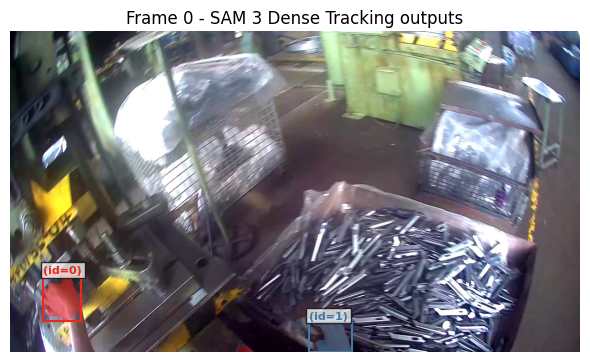

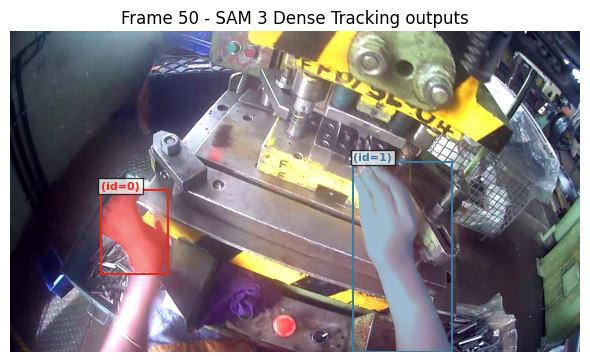

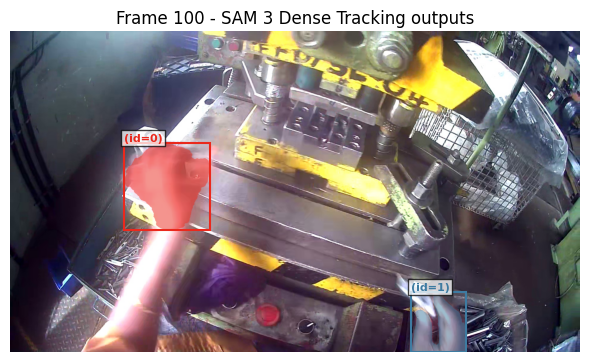

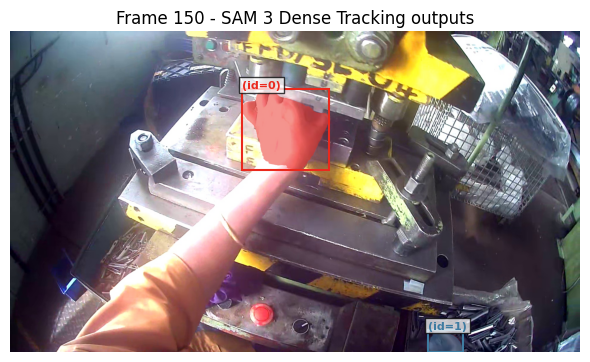


=== Calculating Hand Detection Metrics ===
Calculating hands in frame percentage from 200 frames...
Found 200/200 frames with at least one hand (100.00%)
Calculating both hands in frame percentage from 200 frames...
Found 156/200 frames with both hands (78.00%)

Results:
  Hands in frame: 100.00%
  Both hands in frame: 78.00%
=== Metrics Calculation Complete ===



{'hands_in_frame_pct': 100.0, 'both_hands_in_frame_pct': 78.0}

In [44]:
#Print outputted video frames
visualize_outputs_per_frame(outputs_per_frame, frames_dir, stride = 50)

#Metrics for evaluating quality of video
calculate_hand_metrics(outputs_per_frame)

## 6. Shut Down

In [45]:
predictor.shutdown()